# Prédictions avec le model LENET entrainé

> https://www.tensorflow.org/tutorials/images/classification#visualize_training_results

## Import des librairies

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import PIL
from PIL import Image
import os
import mlflow
import setuptools
import requests
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

print("tensorflow version",tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

2024-07-26 11:04:54.981994: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-26 11:04:55.089378: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-26 11:04:55.138191: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-26 11:04:55.234643: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-26 11:04:55.257760: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-26 11:04:55.381941: I tensorflow/core/platform/cpu_feature_gu

tensorflow version 2.17.0
Num GPUs Available:  0


## Initialisation de MLflow

In [2]:
# Initialisation de l'URL
mlflow_server_uri = "https://champi.heuzef.com"

mlflow.set_tracking_uri(mlflow_server_uri)
mlflow.set_experiment("champi") # Le nom du projet

def is_mlflow_tracking_server_available(mlflow_server_uri):
  try:
    response = requests.get(mlflow_server_uri)
    if response.status_code == 200:
      return True
    else:
      return False
  except requests.exceptions.RequestException:
    return False

if is_mlflow_tracking_server_available(mlflow_server_uri):
  print("Le serveur de tracking MLflow est disponible :", mlflow_server_uri)
else:
  print("Le serveur de tracking MLflow n'est pas disponible.")

requests.get(mlflow_server_uri)

Le serveur de tracking MLflow est disponible : https://champi.heuzef.com


<Response [200]>

In [17]:
# logged_model = 'runs:/27ca3b31dbe1447d9fb7e0f7c6903cda/heuzef_lenet_001_artifacts'
# loaded_model = mlflow.pyfunc.load_model(local_model_path)

local_model_path = "../../models/mlruns/103379370584144202/27ca3b31dbe1447d9fb7e0f7c6903cda/artifacts/heuzef_lenet_001_artifacts/"

loaded_model = tf.keras.models.load_model(local_model_path+"data/model.keras")

loaded_model

<Sequential name=sequential, built=True>

## Préparation des nouvelles donnés pour les predictions

Nos 14 classes sont les suivantes :

In [4]:
mo_db_path="../../data/LAYER2/MO/"
names_csv_path="../../data/LAYER2/names.csv"

def get_champi_name(mo_db_path, names_csv_path):
    """
    Retourne le nom de la classe du champignon depuis le fichier names.csv de Mushroom Observer.
    Requiere numpy, pandas et os.

    Args:
        mo_db_path : Chemin vers le dossier contenant les classes
        names_csv_path : Chemin vers le fichier names.csv

    Returns:
        Dataframe Pandas avec IDs et noms
    """
    # Imports des sources
    data_files = os.listdir(mo_db_path)
    names = pd.read_csv(names_csv_path, delimiter='\t', index_col=0)

    # Recupération des ID des classes
    champi_classes = []
    for item in data_files:
        champi_classes.append(int(item))
    
    # Creation du DataFrame
    df = names[["text_name"]].rename(columns={'text_name': 'name'})
    df = df.loc[champi_classes]

    # Resultat
    return df
    

df = get_champi_name(mo_db_path, names_csv_path)

display(df)

,name
id,
373,Amanita muscaria
50164,Baorangia bicolor
15162,Bolbitius titubans
42,Trametes versicolor
330,Cantharellus cinnabarinus
1174,Ceratiomyxa fruticulosa
382,Amanita bisporigera
344,Boletus edulis
63454,Boletus rex-veris


Nous allons tester une prédiction sur un magnifique Amanita muscaria, bien connu sous le doux nom d'Amanite tue-mouches. Voici une nouvelle photo d'un très beau spécimen :

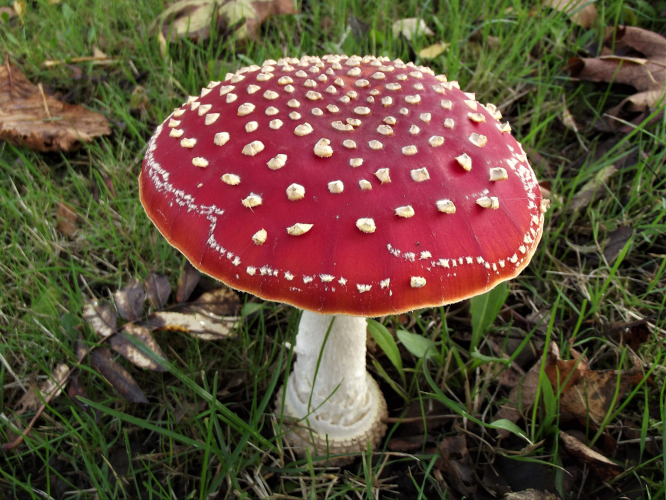

In [69]:
img_path = "predict_001.jpg"
PIL.Image.open(img_path)

Pré-traitement de l'image :

In [70]:
img = tf.keras.utils.load_img(
    img_path, target_size=((224, 224))
)

img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

print(img_array)

tf.Tensor(
[[[[ 91. 124.  53.]
   [ 88. 113.  48.]
   [ 81. 110.  52.]
   ...
   [ 30.  30.  18.]
   [ 30.  44.  11.]
   [ 22.  30.  15.]]

  [[ 90. 115.  50.]
   [ 81. 107.  46.]
   [ 73.  96.  44.]
   ...
   [ 38.  41.  20.]
   [ 38.  56.  18.]
   [ 35.  50.  27.]]

  [[ 87. 101.  48.]
   [ 85.  93.  42.]
   [ 75.  82.  40.]
   ...
   [ 34.  46.  24.]
   [ 37.  59.  20.]
   [ 36.  51.  32.]]

  ...

  [[ 26.  31.   9.]
   [ 32.  35.  16.]
   [ 16.  14.  15.]
   ...
   [ 33.  56.  10.]
   [ 25.  35.  10.]
   [  9.  15.   3.]]

  [[ 27.  32.  12.]
   [ 31.  33.  19.]
   [ 19.  18.  16.]
   ...
   [ 24.  39.   8.]
   [ 15.  24.   7.]
   [  8.  19.   2.]]

  [[ 30.  35.  15.]
   [ 26.  27.  21.]
   [ 27.  26.  24.]
   ...
   [ 18.  27.   8.]
   [ 11.  19.   4.]
   [  8.  16.   1.]]]], shape=(1, 224, 224, 3), dtype=float32)


In [20]:
# Chargement des labels
class_names = np.load('class_names.npy')
class_names

array(['1174', '15162', '1540', '2749', '29997', '330', '344', '362',
       '373', '382', '39842', '42', '50164', '63454'], dtype='<U5')

In [73]:
predictions = loaded_model.predict(img_array)
score = predictions[0]

print(
    "This image most likely belongs to {} with a {:.2f} score confidence."
    .format(df["name"][int(class_names[np.argmax(score)])], np.max(score))
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
This image most likely belongs to Amanita muscaria with a 137.31 score confidence.


In [50]:
pd.DataFrame(tf.nn.softmax(predictions[0]))

,0
0,0.000000e+00
1,0.000000e+00
2,0.000000e+00
3,0.000000e+00
4,0.000000e+00
5,0.000000e+00
6,2.558583e-14
7,0.000000e+00
8,1.000000e+00
9,1.759972e-34


In [52]:
pd.DataFrame(predictions[0])

,0
0,-92.366478
1,-80.526962
2,-143.327332
3,-147.486633
4,4.988295
5,-95.794563
6,106.015625
7,18.973446
8,137.312363
9,59.589764


Aller, une autre pour la route ?

In [60]:
def champi_lenet_predict(url):
    champi_path = tf.keras.utils.get_file(origin=url)
    img = tf.keras.utils.load_img(champi_path, target_size=(224, 224))
    
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)
    
    predictions = loaded_model.predict(img_array)
    score = predictions[0]

    return print("This image most likely belongs to {} with a {:.2f} score confidence.".format(df["name"][int(class_names[np.argmax(score)])], np.max(score)))

In [74]:
champi_lenet_predict("https://upload.wikimedia.org/wikipedia/commons/thumb/8/86/Lactarius_indigo_48568_edit.jpg/1280px-Lactarius_indigo_48568_edit.jpg") # Lactarius indigo

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
This image most likely belongs to Morchella importuna with a 22.73 score confidence.


In [75]:
champi_lenet_predict("https://live.staticflickr.com/339/20275547700_ffd1906d08_h.jpg") # Lactarius indigo

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
This image most likely belongs to Morchella importuna with a 6.52 score confidence.


In [78]:
champi_lenet_predict("https://www.mycodb.fr/photos/Amanita_muscaria_2005_ov_2.jpg") # Amanita muscaria

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
This image most likely belongs to Amanita muscaria with a 60.18 score confidence.


In [80]:
champi_lenet_predict("https://upload.wikimedia.org/wikipedia/commons/thumb/a/a3/Amanita_bisporigera_17932.jpg/1024px-Amanita_bisporigera_17932.jpg") # Amanita Bisporigera

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
This image most likely belongs to Amanita augusta with a 14.68 score confidence.


In [82]:
champi_lenet_predict("https://micoex.org/wp-content/uploads/stories/Bolbitius-vitellinus1.jpg") # Bolbitius vitellinus

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
This image most likely belongs to Amanita augusta with a 13.94 score confidence.


In [83]:
champi_lenet_predict("https://botany.cz/foto/slzecnikherb1.jpg") # Bolbitius vitellinus

102400/102400 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
This image most likely belongs to Boletinellus merulioides with a 19.33 score confidence.
